`Project Title` : **Quora Question Pair Similarity Project**

`Technologies` : **ML, NLP, MLOPs**

`Domain` : **Social Networking**

`Project Difficulties Level` : **Advance**

`Project Team` : **Data Aventura**

#### 1. Description

Quora serves as a platform where individuals can acquire and exchange knowledge on a wide range of topics. It offers the opportunity to ask questions and connect with people who contribute unique insights and high-quality answers. This empowers individuals to learn from one another and gain a deeper understanding of the world.

With over 100 million monthly visitors, it's not surprising that many people pose similar questions on Quora. However, having multiple questions with the same intent can lead to seekers spending more time searching for the best answer to their question, while also pressuring writers to address multiple versions of the same question. Quora places significant value on canonical questions because they enhance the experience for active seekers and writers, providing long-term benefits and more value to both groups.

The following points summarize key considerations:

1. Misclassifying questions can have severe consequences.
2. A probability estimation for question pairs being duplicates would allow flexibility in selecting an appropriate threshold.
3. There are no strict concerns regarding response time.
4. Partial importance is placed on interpretability.


#### 2. Problem Statement

- The objective is to determine which questions asked on Quora are duplicates of questions that have already been asked.
- This information can be useful in promptly providing answers to questions that have already been addressed.
- We aim to predict whether a pair of questions are duplicates or not.
#### 3. Data

- The data is provided in a file called Train.csv.
- Train.csv consists of 5 columns: qid1, qid2, question1, question2, is_duplicate.
- The size of Train.csv is 60MB.
- The number of rows in Train.csv is 404,290.

In [58]:
pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
pip install distance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
from tqdm import tqdm, tqdm_notebook
# Register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`

tqdm.pandas()

In [62]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import nltk
import distance
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

import warnings
warnings.filterwarnings('ignore')

In [63]:
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [64]:
df = pd.read_csv('https://github.com/Koorimikiran369/Quora-Question-Pairing/raw/main/train.csv.zip')

In [65]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [66]:
df.tail()

,id,qid1,qid2,question1,question2,is_duplicate
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


In [67]:
print('Number of Rows:', df.shape[0])
print('Number of Columns:', df.shape[1])

Number of Rows: 404290
Number of Columns: 6


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [69]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [70]:
df.duplicated().sum()

0

In [71]:
df = df.dropna()

In [72]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404287.000000,404287.000000,404287.000000,404287.000000
mean,202144.340337,217243.151093,220955.212082,0.369201
std,116708.673691,157751.614317,159903.168488,0.482589
min,0.000000,1.000000,2.000000,0.000000
25%,101071.500000,74436.500000,74726.500000,0.000000
50%,202145.000000,192181.000000,197053.000000,0.000000
75%,303216.500000,346573.000000,354692.000000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


#### Exploratory Data Analysis (EDA)
`Distribution of data points among output classes`
- Number of duplicate(smilar) and non-duplicate(non similar) questions

In [73]:
print(df['is_duplicate'].value_counts())
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)

0    255024
1    149263
Name: is_duplicate, dtype: int64
0    63.079941
1    36.920059
Name: is_duplicate, dtype: float64


#### Number of Unique Questions

In [74]:
#Creating a dataframe that contains the question ID of both qid1 and qid2
qids = pd.Series(list(df['qid1']) + list(df['qid2']))

#Counting the total number of unique questions
unique_qs = len(np.unique(qids))
print('Total number of Unique Questions are: {}\n'.format(unique_qs))

#Counting the number of unique questions that appear more than once
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
percentage = round(qs_morethan_onetime / unique_qs * 100, 2)
print('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime, percentage))

#Finding the maximum number of times a single question is repeated
max_repeated = max(qids.value_counts())
print('Max number of times a single question is repeated: {}\n'.format(max_repeated))

#Printing the frequency of all questions
q_vals = qids.value_counts()
print(q_vals)

Total number of Unique Questions are: 537929

Number of unique questions that appear more than one time: 111778 (20.78%)

Max number of times a single question is repeated: 157

2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
416446      1
416444      1
416441      1
416439      1
537933      1
Length: 537929, dtype: int64


In [75]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


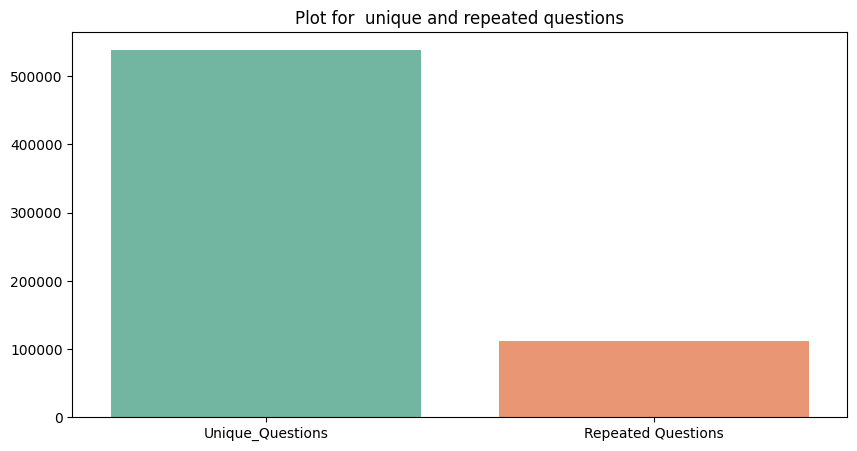

In [76]:
x = ['Unique_Questions' , 'Repeated Questions']
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 5))
plt.title('Plot for  unique and repeated questions')
sns.barplot(x=x, y=y, palette='Set2')
plt.show()

The highest frequency at which a single question appears is: 157



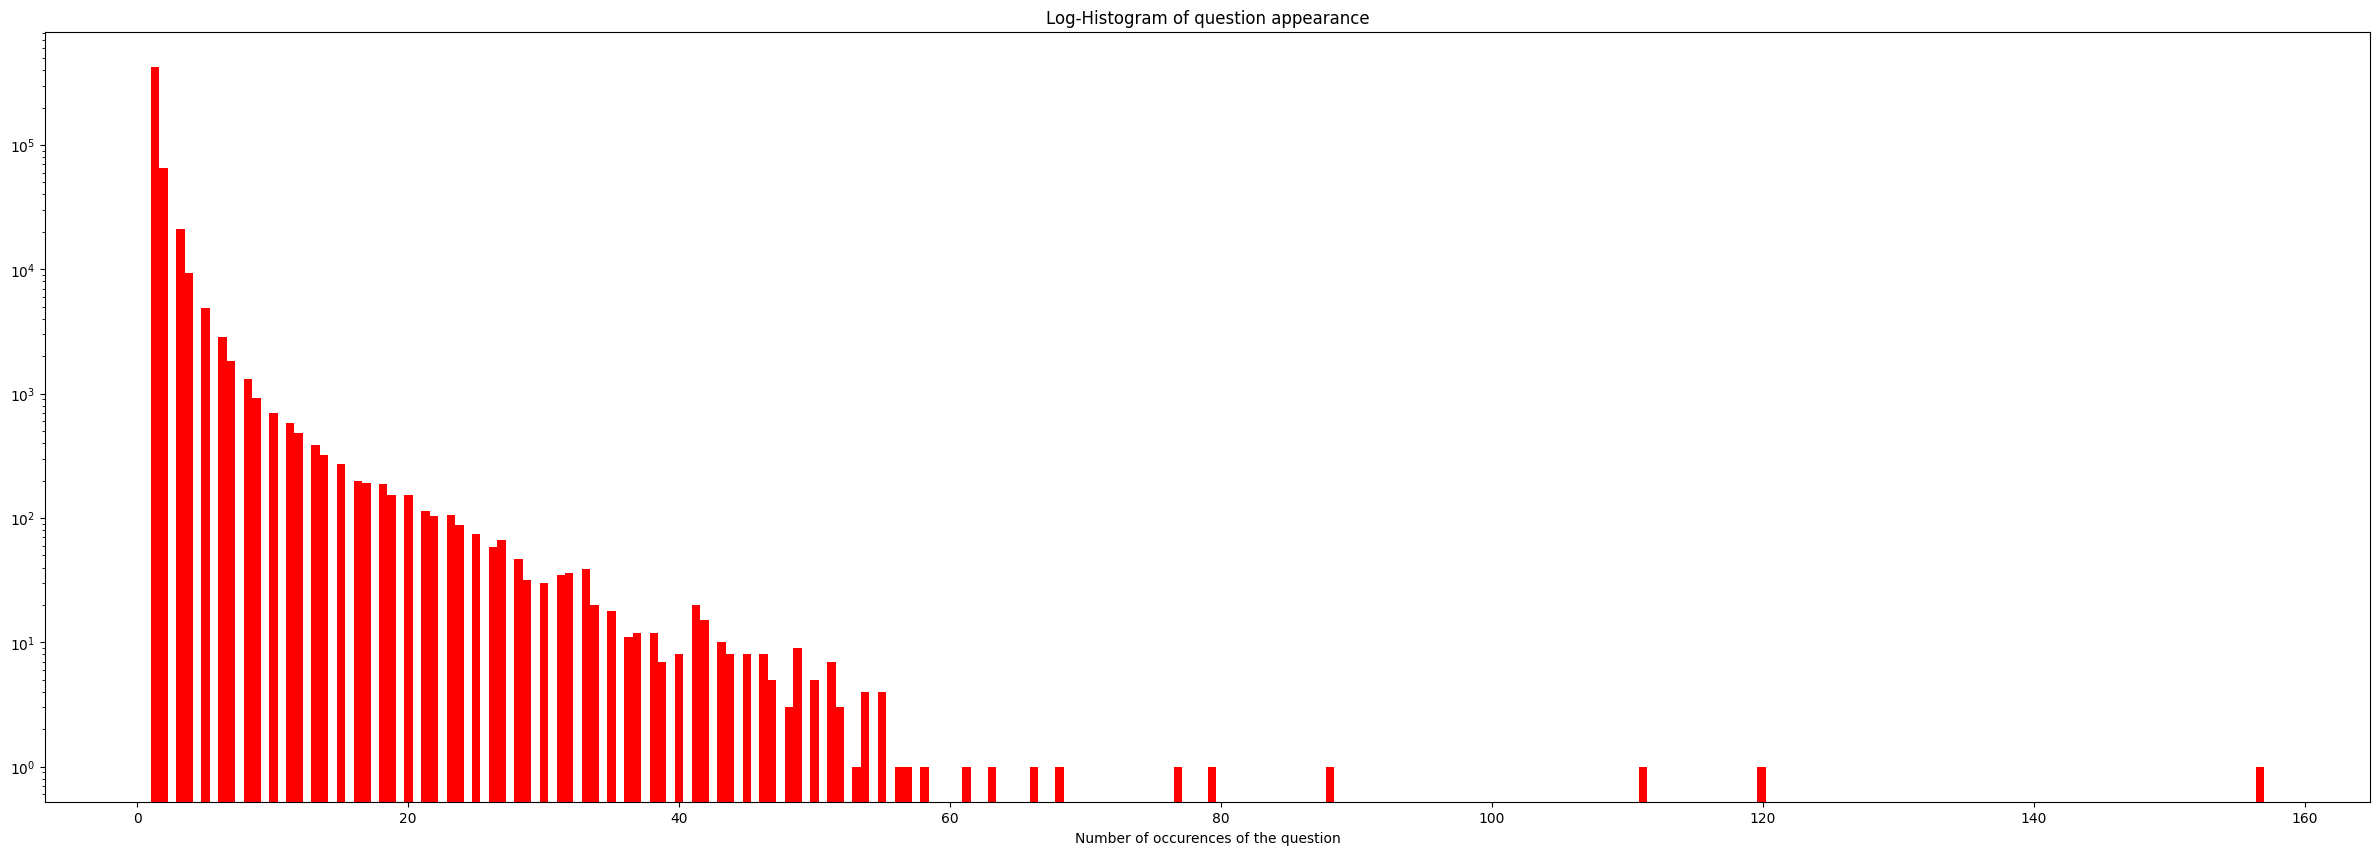

In [77]:
plt.figure(figsize=(30,10))
plt.hist(qids.value_counts(), bins=250, color='red')
plt.yscale('log')
plt.title('Log-Histogram of question appearance')
plt.xlabel('Number of occurences of the question')
print ('The highest frequency at which a single question appears is: {}\n'.format(max(qids.value_counts()))) 

#### Basic Feature Extraction


- **q1len** = Length of q1


- **q2len** = Length of q2


- **q1_words** = Number of words in Question 1


- **q2_words** = Number of words in Question 2


- **Common_words** = (Number of common unique words in Question 1 and Question 2)


- **Total_words** =(Total num of words in Question 1 + Total num of words in Question 2


- **shared_words** = (Common_words)/(Total_words)

In [78]:
# Calculating length of Questions
df['q1_Len'] = df['question1'].str.len() 
df['q2_Len'] = df['question2'].str.len()

In [79]:
# Calculating the number of words in a Question
df['q1_Words'] = df['question1'].apply(lambda row : len(row.split()))   
df['q2_Words'] = df['question2'].apply(lambda row : len(row.split())) 

In [80]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_Len,q2_Len,q1_Words,q2_Words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7


In [81]:
# Calculating number of common words in Question 1 and Question 2
def common_words(row):
    q1_w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    q2_w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(q1_w1 & q2_w2)

In [82]:
df['common_words'] = df.apply(common_words, axis=1)

In [83]:
# Calculating the total number of words in both the questions
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [84]:
df['total_words'] = df.apply(total_words, axis=1)

In [85]:
# Calculating the ratio share of words between question1 and question2
df['shared_words']=round(df['common_words']/df['total_words'],2)

In [86]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_Len,q2_Len,q1_Words,q2_Words,common_words,total_words,shared_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,10,23,0.43
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,4,20,0.20
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,4,24,0.17
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0,19,0.00
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,2,20,0.10


#### Analysis of some of the Extracted Features

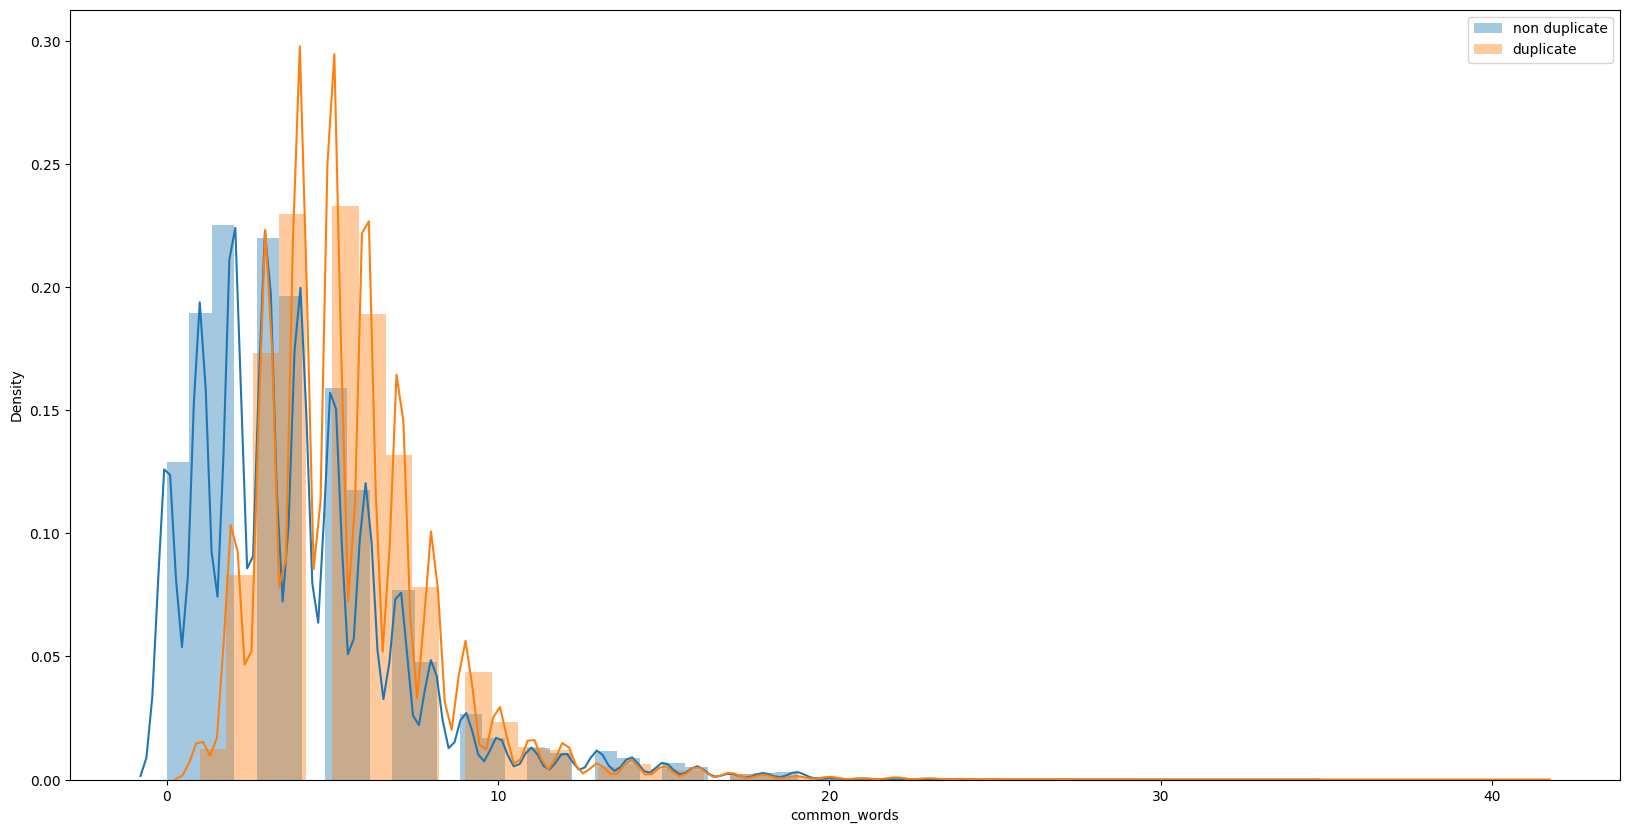

In [87]:
# Common words
plt.figure(figsize=(20, 10))
sns.distplot(df[df['is_duplicate'] == 0]['common_words'], label='non duplicate',)
sns.distplot(df[df['is_duplicate'] == 1]['common_words'], label='duplicate')
plt.legend()
plt.show()

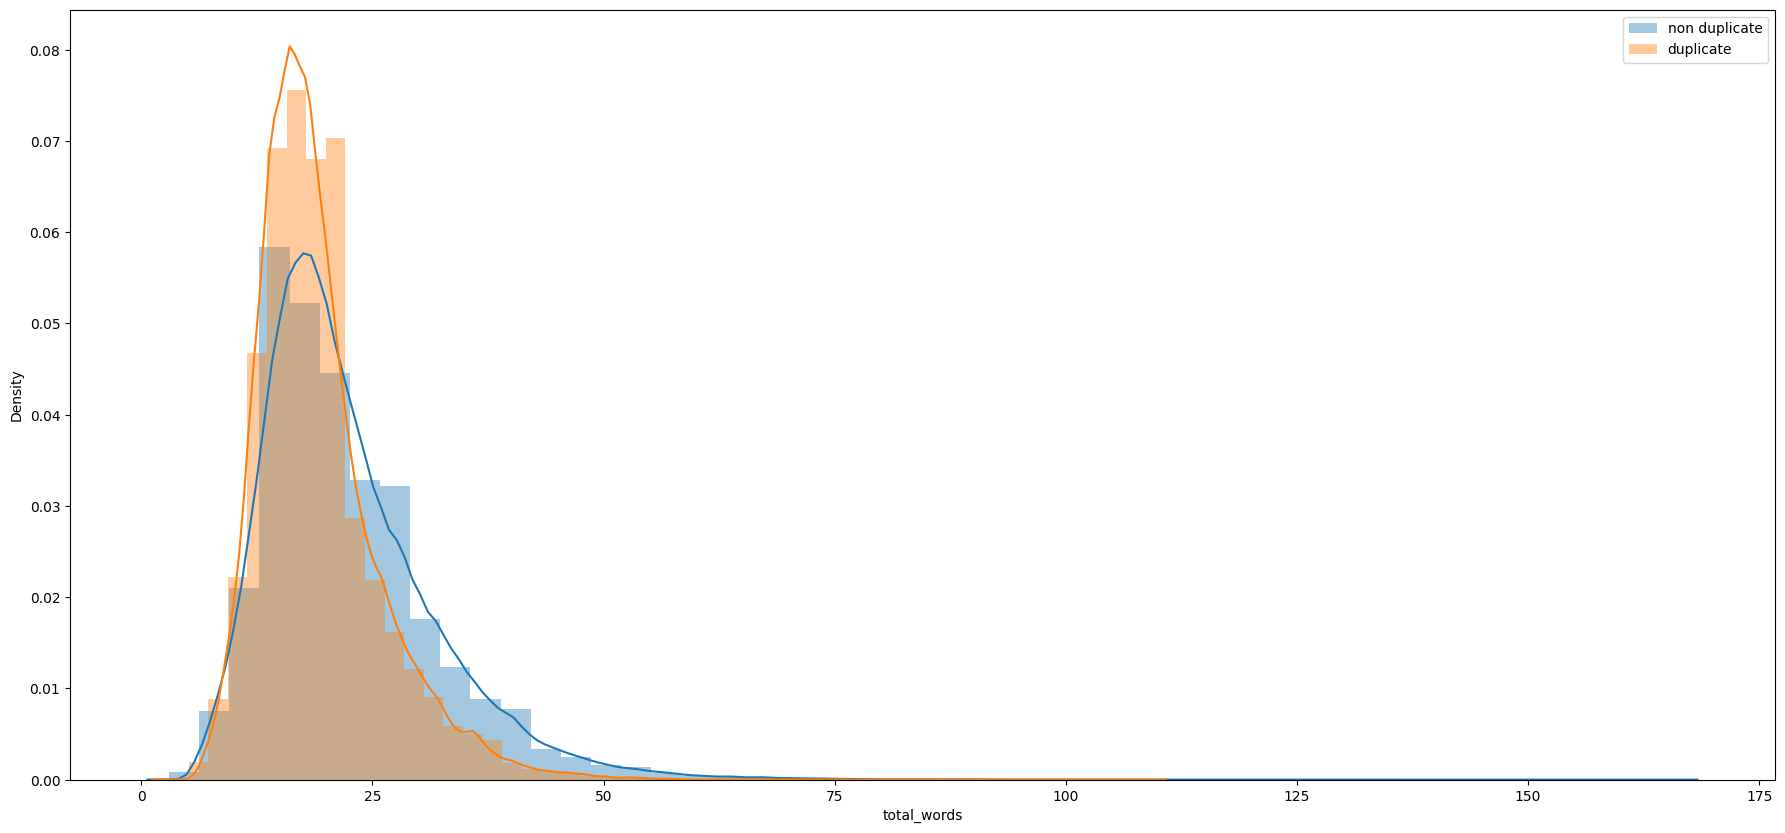

In [88]:
# Total words
plt.figure(figsize=(22, 10))
sns.distplot(df[df['is_duplicate'] == 0]['total_words'], label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['total_words'], label='duplicate')
plt.legend()
plt.show()

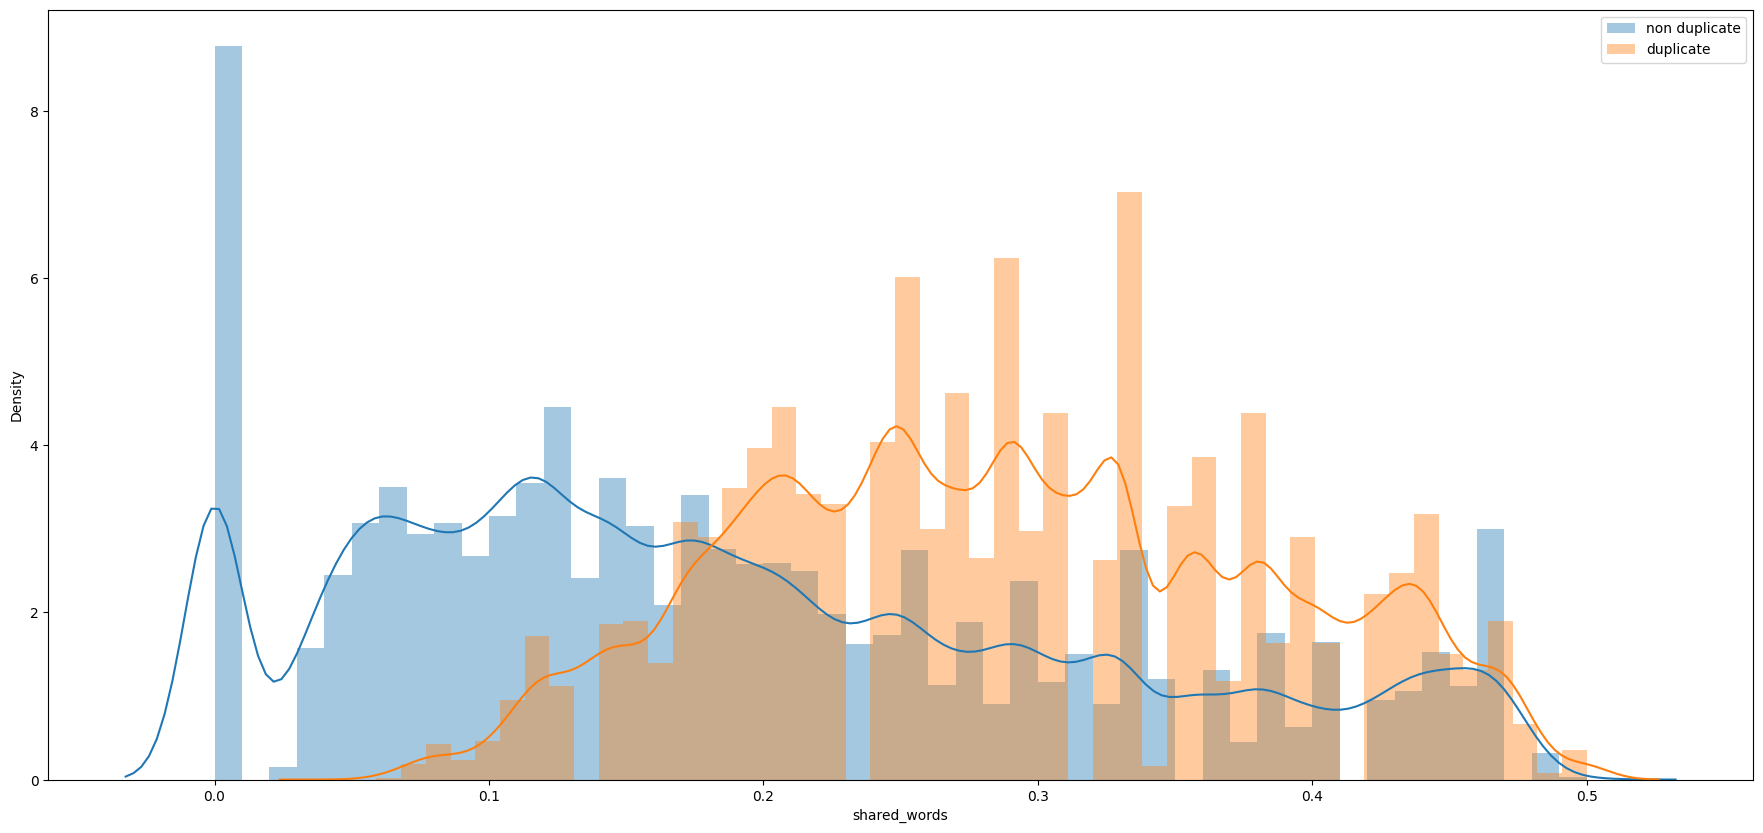

In [89]:
# Shared words
plt.figure(figsize=(22, 10))
sns.distplot(df[df['is_duplicate'] == 0]['shared_words'], label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['shared_words'], label='duplicate')
plt.legend()
plt.show()

In [90]:
def pre_process(raw_text, flag):
    # Remove non-alphabetic characters
    sent = re.sub("[^a-zA-Z]", " ", raw_text)

    sentence = sent.lower()

    # Expand contractions
    expanded_words = [contractions.fix(word) for word in sentence.split()]
    sentence = ' '.join(expanded_words)

    # Remove stop words
    clean_tokens = [t for t in sentence.split() if t not in stopwords.words("english")]

    # Stemming/Lemmatization and POS tagging
    if flag == 'stem':
        stemmer = PorterStemmer()
        token_list = []
        for word, tag in pos_tag(clean_tokens):
            wntag = tag[0].lower()
            wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
            stem = stemmer.stem(word, wntag) if wntag else word
            token_list.append(stem)
    else:
        lemmatizer = WordNetLemmatizer()
        token_list = []
        for word, tag in pos_tag(clean_tokens):
            wntag = tag[0].lower()
            wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
            lemma = lemmatizer.lemmatize(word, wntag) if wntag else word
            token_list.append(lemma)

    return pd.Series([" ".join(token_list)])

In [91]:
df['question1'] = df['question1'].apply(str)
df['question2'] = df['question2'].apply(str)

In [92]:
# Doing Pre-processing on both question1 and question2

df['cleanQ1_lemma'] = df['question1'].progress_apply(lambda x: pre_process(x, 'lemma'))
df['cleanQ2_lemma'] = df['question2'].progress_apply(lambda x: pre_process(x, 'lemma'))

100%|██████████| 404287/404287 [09:11<00:00, 733.39it/s]


In [93]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_Len,q2_Len,q1_Words,q2_Words,common_words,total_words,shared_words,cleanQ1_lemma,cleanQ2_lemma
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,10,23,0.43,step step guide invest share market india,step step guide invest share market
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,4,20,0.20,story kohinoor koh noor diamond,would happen indian government steal kohinoor ...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,4,24,0.17,increase speed internet connection use vpn,internet speed increase hack dns
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0,19,0.00,mentally lonely solve,find remainder math math divide
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,2,20,0.10,one dissolve water quikly sugar salt methane c...,fish would survive salt water


#### Advance Feature Engineering Using NLP and Fuzzy Features


* Token: You get a token by splitting sentence a space
* Stop_Word : stop words as per NLTK
* Word : A token that is not a stop_word


* **cwc_min**

>cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2

>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))

* **cwc_max**

>cwc_max__ : Ratio of common_word_count to max lenghth of word count of Q1andQ2

>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))

* **csc_min**

>csc_min__ : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 

>csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))

* **csc_max**

>csc_max__ : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2 

>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))

* **ctc_min**

>ctc_min__ : Ratio of common_token_count to min lenghth of token count of Q1 and Q2

>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))

* **ctc_max**

>ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2 

>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))

* **last_word_eq**

>last_word_eq : Check if Last word of both questions is equal or not 

>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])

* **first_word_eq**

>first_word_eq : Check if First word of both questions is equal or not 

>first_word_eq = int(q1_tokens[0] == q2_tokens[0])

In [94]:
# Advanced Features

def fetch_token_features(row):
    q1 = row['cleanQ1_lemma']
    q2 = row['cleanQ2_lemma']
    
    SAFE_DIV = 0.0001 
    STOP_WORDS = set(stopwords.words("english"))
    
    token_features = [0.0] * 8
    
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set(word for word in q1_tokens if word not in STOP_WORDS)
    q2_words = set(word for word in q2_tokens if word not in STOP_WORDS)

    # Get the stopwords in Questions
    q1_stops = set(word for word in q1_tokens if word in STOP_WORDS)
    q2_stops = set(word for word in q2_tokens if word in STOP_WORDS)

    # Get the common non-stopwords, stopwords, tokens from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    common_stop_count = len(q1_stops.intersection(q2_stops))
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
   
    # Check if last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
   
    # Check if first word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [95]:
token_features = df.apply(fetch_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [109]:
def abs_len_diff(q1,q2):
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
  
    # Absolute length features
    abs_len = abs(len(q1_tokens) - len(q2_tokens))
    return abs_len

def mean_len(q1,q2):
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    # Average Token Length of both Questions
    mean_len = (len(q1_tokens) + len(q2_tokens))/2
    return mean_len

def longest_substr_ratio(q1, q2):
    strs = list(distance.lcsubstrings(q1, q2))
    if len(strs) == 0:
        return 0
    else:
        return round(len(strs[0]) / (min(len(q1), len(q2)) + 1),5)

* **abs_len_diff**: Abs. length difference 
>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))

* **mean_len**: Average Token Length of both Questions 
>mean_len = (len(q1_tokens) + len(q2_tokens))/2

* **longest_substr_ratio** : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2

>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [110]:
df['abs_len_diff'] = df.apply(lambda x: abs_len_diff(x["cleanQ1_lemma"], x["cleanQ2_lemma"]), axis=1)
df['mean_len'] = df.apply(lambda x: mean_len(x["cleanQ1_lemma"], x["cleanQ2_lemma"]), axis=1)
df['longest_substr_ratio'] = df.apply(lambda x: longest_substr_ratio(x["cleanQ1_lemma"], x["cleanQ2_lemma"]), axis=1)

In [111]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_Len,q2_Len,q1_Words,q2_Words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,...,0.714276,0.0,1.0,1,6.5,0.97222,92,100,92,100
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,...,0.399996,0.0,0.0,5,7.5,0.81250,57,90,59,89
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,...,0.499992,0.0,0.0,1,5.5,0.27273,27,51,68,84
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,...,0.000000,0.0,0.0,2,4.0,0.04545,23,29,23,26
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,...,0.199998,0.0,0.0,5,7.5,0.20000,25,52,40,51


In [112]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['cleanQ1_lemma']
    q2 = row['cleanQ2_lemma']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

* **Fuzz Ratio** : Measurement of edit distance (Minimum number of edits required to convert one sentence to other )

* **Fuzz Partial Ratio** : How much accuratly a part of sentence match to other sentence ("Chennai Super Kings", "Super Kings")

* **Token Sort Ratio** : Tokenizing the string in question, sorting the tokens alphabetically, and then joining them back into a string

* **Token Set Ratio** : Tokenize both strings,split the tokens into two groups of intersection and remainder. We use those sets to build up a comparison string.

In [101]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [102]:
print(df.shape)
df.head()

(404287, 30)


,id,qid1,qid2,question1,question2,is_duplicate,q1_Len,q2_Len,q1_Words,q2_Words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,...,0.714276,0.0,1.0,1,6.5,0.97222,92,100,92,100
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,...,0.399996,0.0,0.0,5,7.5,0.81250,57,90,59,89
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,...,0.499992,0.0,0.0,1,5.5,0.27273,27,51,68,84
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,...,0.000000,0.0,0.0,2,4.0,0.04545,23,29,23,26
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,...,0.199998,0.0,0.0,5,7.5,0.20000,25,52,40,51


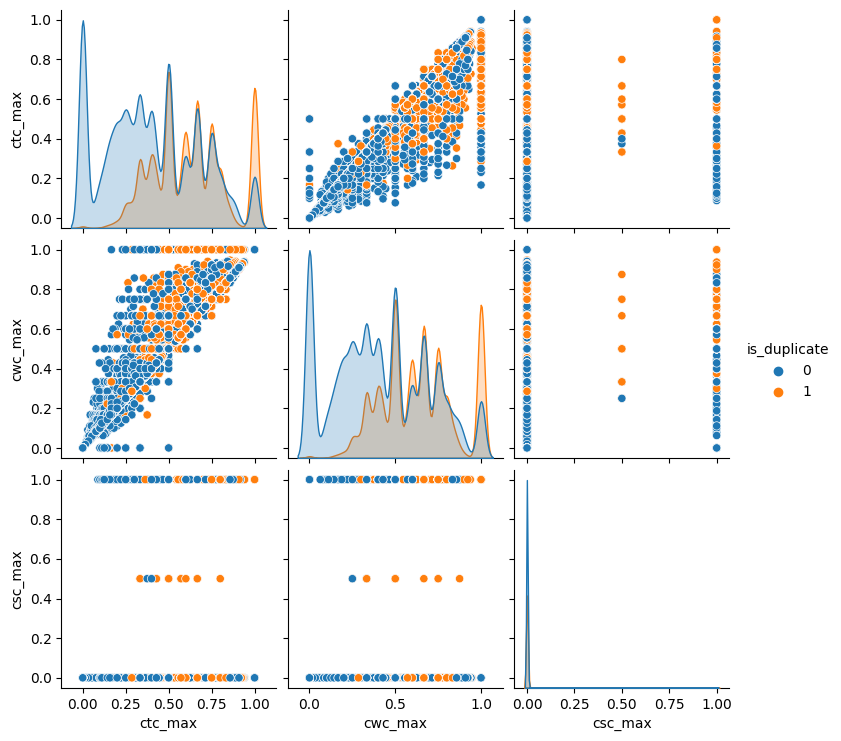

In [103]:
sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

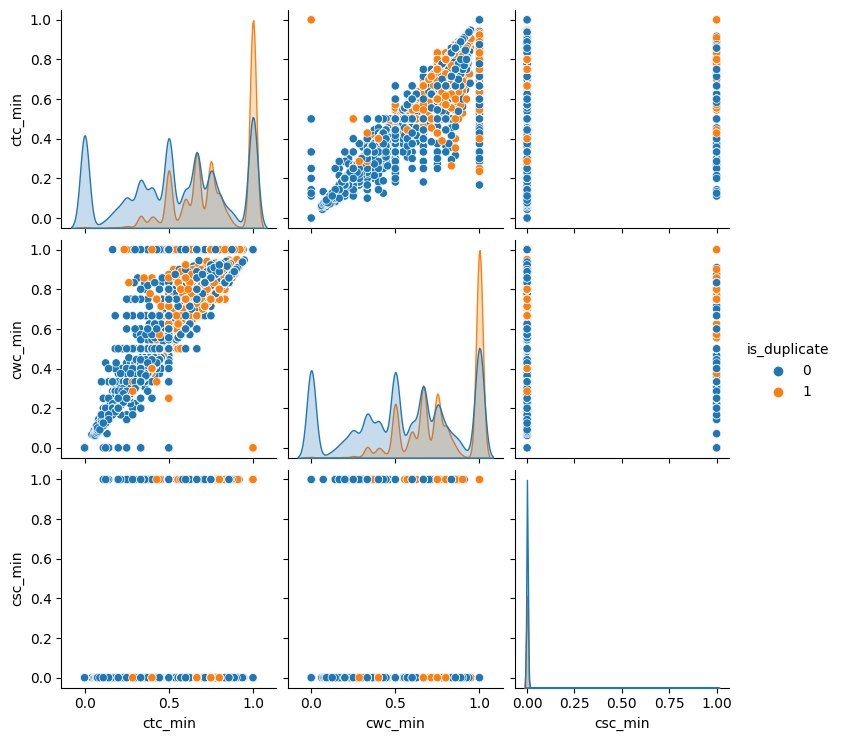

In [104]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

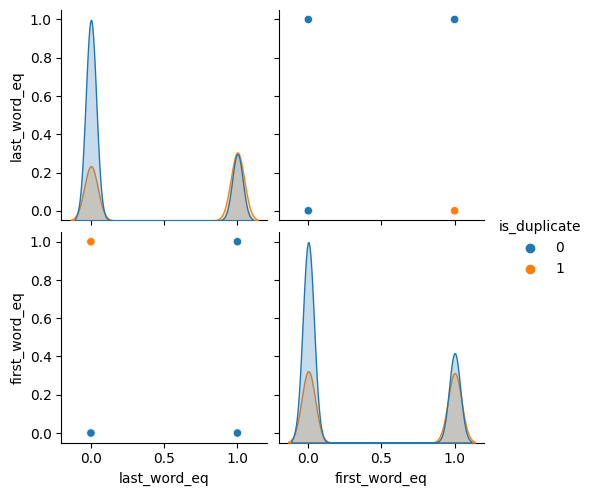

In [105]:
sns.pairplot(df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

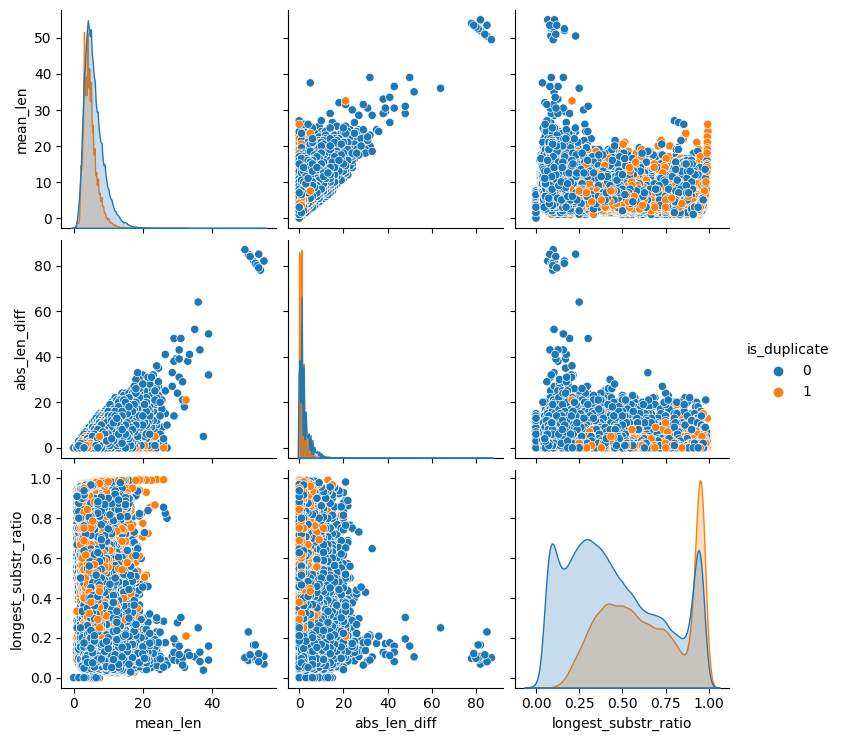

In [106]:
sns.pairplot(df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

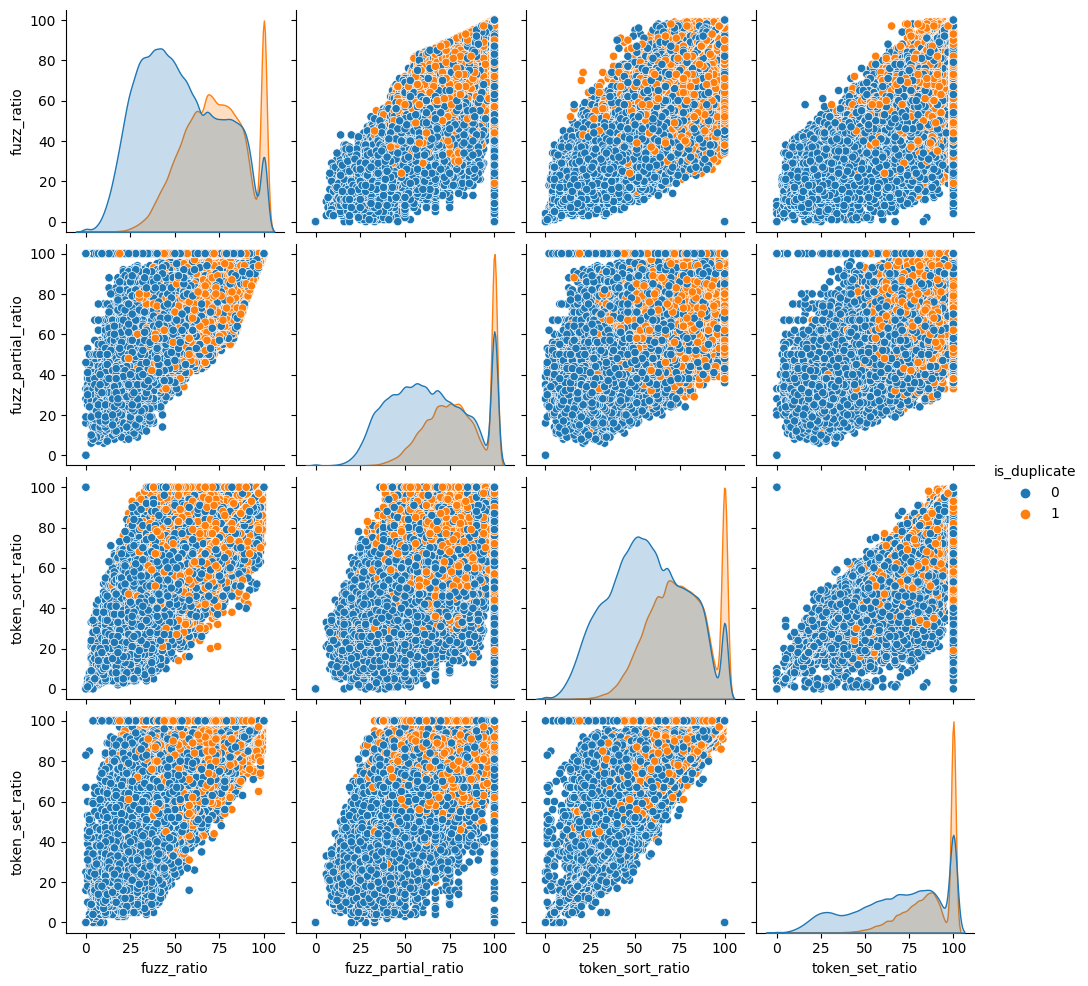

In [107]:
sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')